<a href="https://colab.research.google.com/github/JakobUniver/Traffic-sign-detection-in-color-videos/blob/main/test_lenet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from google.colab.patches import cv2_imshow

In [6]:
!ls

README.dataset.txt   test				       valid
README.roboflow.txt  Traffi_and_Road_Signs_v1i_multiclass.zip
sample_data	     train


In [5]:
!unzip -q ./Traffi_and_Road_Signs_v1i_multiclass.zip

In [7]:
data_df = pd.read_csv("train/_classes.csv")
data_df.shape

(7092, 30)

In [8]:
num_classes = len(data_df.columns)-1
num_classes

29

In [9]:
imgs_org = data_df.apply(lambda row: cv2.imread('/content/train/'+row['filename']), axis=1)

In [10]:
new_shape = (64,64)
imgs = imgs_org.apply((lambda img: cv2.resize(img, new_shape, interpolation=cv2.INTER_AREA)))
imgs = imgs.apply((lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))

In [11]:
imgs = np.array(list(imgs))

filename                                00033_00002_00001_png_jpg.rf.b974e1342a26f2404...
 -Road narrows on right                                                                 0
 50 mph speed limit                                                                     0
 Attention Please-                                                                      0
 Beware of children                                                                     0
 CYCLE ROUTE AHEAD WARNING                                                              0
 Dangerous Left Curve Ahead                                                             0
 Dangerous Rright Curve Ahead                                                           0
 End of all speed and passing limits                                                    0
 Give Way                                                                               0
 Go Straight or Turn Right                                                              0
 Go straig

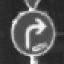

In [12]:
id = 7000
print(data_df.iloc[id])
cv2_imshow(imgs[id])

In [13]:
#mu = imgs.mean(axis=(0)) # finds mean of R, G and B separately
#std = imgs.std(axis=(0)) # same for std
#X_norm = (imgs - mu)/std
#print(mu, std)

In [14]:
#X_norm.shape

In [15]:
img_shape = imgs[0].shape
img_shape

(64, 64)

In [19]:
#y = data_df.apply(lambda row: [np.where(row.values[1:num_classes+1] == 1)[0][0]], axis=1)
#y = data_df.apply(lambda row: np.where(row.values[1:num_classes+1] == 1)[0][0], axis=1)
y = data_df.apply(lambda row: row.values[1:num_classes+1], axis=1)
#y = np.array(list(y),dtype=bool)

In [20]:
y[id]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0], dtype=object)

In [21]:
y_label = np.array(list([[l.argmax()]for l in y]))
y_label.shape

(7092, 1)

In [22]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout,Normalization

In [23]:
normalizer = Normalization()
normalizer.adapt(imgs)

In [24]:
x = Input(shape=(img_shape[0],img_shape[1],3 if len(img_shape) == 3 else 1))
n = normalizer(x)
c1 = Conv2D(60, (5, 5), strides=(1, 1), padding="same")(n)
b1 = BatchNormalization()(c1)
a1 = Activation('tanh')(b1)

c2 = Conv2D(60, (5, 5), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('tanh')(b2)

p3 = MaxPooling2D(pool_size=2)(a2)

c4 = Conv2D(30, (5, 5), strides=(1, 1), padding="valid")(p3)
b4 = BatchNormalization()(c4)
a4 = Activation('tanh')(b4)

c5 = Conv2D(30, (5, 5), strides=(1, 1), padding="same")(a4)
b5 = BatchNormalization()(c5)
a5 = Activation('tanh')(b5)

p6 = MaxPooling2D(pool_size=2, padding="same")(a5)
d6 = Dropout(rate=0.5)(p6)
f6 = Flatten()(d6)

h7 = Dense(500)(f6)
b7 = BatchNormalization()(h7)
a7 = Activation('tanh')(b7)


h8 = Dense(500)(a7)
b8 = BatchNormalization()(h8)
a8 = Activation('softmax')(b8)
d8 = Dropout(rate=0.5)(a8)

z = Dense(num_classes)(d8)
p = Activation('softmax')(z)
model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 64, 64, 64)       129       
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 60)        96060     
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 60)       240       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 60)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 60)        90060 

In [26]:
history = model.fit(imgs,y_label, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
178/178 [==============================] - 16s 33ms/step - loss: 3.2888 - accuracy: 0.4079 - val_loss: 3.1523 - val_accuracy: 0.6378
Epoch 2/20
178/178 [==============================] - 5s 29ms/step - loss: 3.1194 - accuracy: 0.5572 - val_loss: 2.9107 - val_accuracy: 0.7921
Epoch 3/20
178/178 [==============================] - 5s 30ms/step - loss: 2.9318 - accuracy: 0.6600 - val_loss: 2.6549 - val_accuracy: 0.8640
Epoch 4/20
178/178 [==============================] - 6s 31ms/step - loss: 2.7307 - accuracy: 0.7374 - val_loss: 2.4067 - val_accuracy: 0.8922
Epoch 5/20
178/178 [==============================] - 5s 29ms/step - loss: 2.5156 - accuracy: 0.7772 - val_loss: 2.1244 - val_accuracy: 0.9302
Epoch 6/20
178/178 [==============================] - 5s 29ms/step - loss: 2.2918 - accuracy: 0.8010 - val_loss: 1.8676 - val_accuracy: 0.9528
Epoch 7/20
178/178 [==============================] - 5s 30ms/step - loss: 2.0970 - accuracy: 0.8040 - val_loss: 1.6204 - val_accuracy: 0.964

Text(0.5, 1.0, 'Accuracy')

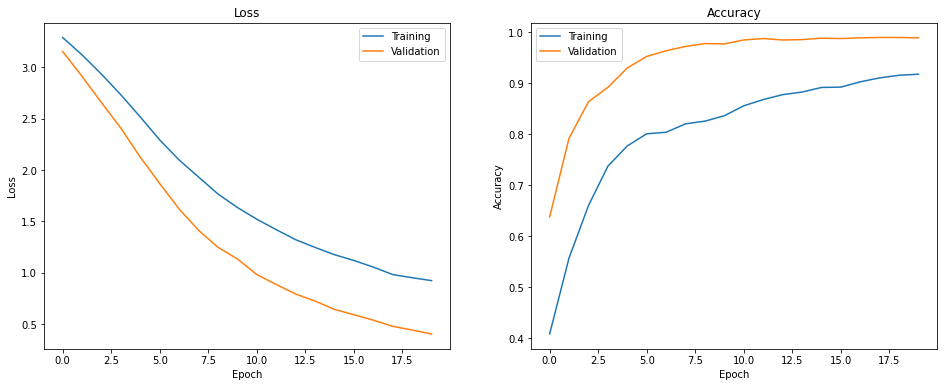

In [27]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

shape (64, 64)
expected class:  Turn right ahead label_id: 27


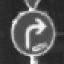

In [28]:
print('shape',imgs[id].shape)
#print(data_df.iloc[id])
expected_class = data_df.iloc[id].values[1:num_classes+1].argmax()
print('expected class:',data_df.columns[expected_class+1],'label_id:',expected_class)
cv2_imshow(imgs[id])

In [29]:
model.predict(np.array([imgs[id]])).argmax()

1/1 [==============================] - 1s 574ms/step


27

In [30]:
model.save('lenet_model')


In [32]:
!zip -r lenet_model.zip lenet_model

  adding: lenet_model/ (stored 0%)
  adding: lenet_model/assets/ (stored 0%)
  adding: lenet_model/variables/ (stored 0%)
  adding: lenet_model/variables/variables.index (deflated 73%)
  adding: lenet_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: lenet_model/keras_metadata.pb (deflated 93%)
  adding: lenet_model/saved_model.pb (deflated 89%)


In [33]:
keras.models.load_model("lenet_model")
model.predict(np.array([imgs[id]])).argmax()

1/1 [==============================] - 0s 16ms/step


27

In [36]:
# test model
!ls -l lenet_model.zip

-rw-r--r-- 1 root root 33625732 Nov 25 19:26 lenet_model.zip
